In [2]:
import itertools
import pandas as pd
import numpy as np
import os
import post_proc as pp
import csv
import threading
import multiprocessing as mp
import LP as optim
import pyomo
import matplotlib.pyplot as plt

In [104]:
df_total=pd.read_csv('../Output/aggregated_results.csv',sep=';')

In [ ]:
df_bf=pd.read_csv(''../Output/aggregated_results.csv',sep=';')

In [105]:
df_total.keys()

Index(['E_PV_batt', 'E_PV_bu', 'E_PV_budhw', 'E_PV_curt', 'E_PV_grid',
       'E_PV_hp', 'E_PV_hpdhw', 'E_PV_load', 'E_batt_bu', 'E_batt_budhw',
       'E_batt_hp', 'E_batt_hpdhw', 'E_batt_load', 'E_bu', 'E_budhw', 'E_char',
       'E_cons', 'E_dis', 'E_grid_batt', 'E_grid_bu', 'E_grid_budhw',
       'E_grid_hp', 'E_grid_hpdhw', 'E_grid_load', 'E_hp', 'E_hpdhw',
       'E_loss_Batt', 'E_loss_conv', 'E_loss_inv', 'E_loss_inv_PV',
       'E_loss_inv_batt', 'E_loss_inv_grid', 'Q_dhwst_hd', 'Q_hp_sh',
       'Q_hp_ts', 'Q_loss_dhwst', 'Q_loss_ts', 'Q_ts', 'Q_ts_delta', 'Q_ts_sh',
       'T_dhwst', 'T_ts', 'E_demand', 'E_PV', 'Req_kWh', 'Req_kWh_DHW',
       'Set_T', 'Temp', 'Temp_supply', 'Temp_supply_tank', 'T_aux_supply',
       'COP_tank', 'COP_SH', 'COP_DHW', 'E_demand_hp_pv_dhw', 'E_demand_hp_pv',
       'E_demand_pv', 'TSC', 'DSC', 'ISC', 'CU', 'EFC_nolifetime', 'BS', 'LS1',
       'LS2', 'LS3', 'LS4', 'LS5', 'PS1', 'PS2', 'PS3', 'PS4', 'PS5',
       'App_comb', 'conf', 'Capacity', '

In [ ]:
df_total.groupby(['App_comb', 'conf', 'Capacity', 'Tech', 'PV_nom', 'cluster', 'hh',
       'country', 'quartile', 'cases', 'house_type']).count()

In [109]:
df_total[(df_total.hh==110141955880)&(df_total.App_comb==3)].loc[:,['App_comb', 'conf', 'Capacity', 'Tech', 'PV_nom', 'cluster', 'hh',
       'country', 'quartile', 'cases', 'house_type', 'HP', 'SOC_mean',
       'P_drained_max', 'P_injected_max']]

,App_comb,conf,Capacity,Tech,PV_nom,cluster,hh,country,quartile,cases,house_type,HP,SOC_mean,P_drained_max,P_injected_max
536,3.0,0.0,7.0,NMC,4.8,[0.],110141955880,CH,50,mean,SFH100,AS,94.613333,8.902231,3.8
559,3.0,0.0,7.0,NMC,4.8,[0.],110141955880,CH,50,mean,SFH15,AS,94.613333,3.465290,3.8
1513,3.0,0.0,7.0,NMC,4.8,[0.],110141955880,CH,50,mean,SFH45,AS,94.613333,3.465290,3.8
1881,3.0,2.0,7.0,NMC,4.8,[0.],110141955880,CH,50,mean,SFH15,AS,94.613333,3.465290,3.8


In [4]:
df_orig=pd.read_csv('Input/Electricity_demand_supply_2017.csv',sep=',',engine='python',index_col=[1],
                    parse_dates=[1],infer_datetime_format=True )
if np.issubdtype(df_orig.index.dtype, np.datetime64):
    df_orig.index=df_orig.index.tz_localize('UTC').tz_convert('Europe/Brussels')
else:
    df_orig.index=pd.to_datetime(df_orig.index,utc=True)
    df_orig.index=df_orig.index.tz_convert('Europe/Brussels')

In [5]:
df_orig.head()

,Unnamed: 0,110141755827,110141755828,110141755829,110141755830,110141755831,110141755832,110141755833,110141755834,110141755835,...,1127352129767,1127353129781,1127354129797,1127354129799,1127355129773,1127355129783,1127355129784,1127355129786,113350355883,E_PV
index,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00+01:00,0,0.18,0.05,0.04,0.19,0.02,0.02,0.05,0.03,0.13,...,0.10,0.06,0.07,0.08,0.10,0.01,0.01,0.02,0.58,0.0
2017-01-01 00:15:00+01:00,1,0.17,0.06,0.02,0.03,0.04,0.00,0.04,0.00,0.10,...,0.01,0.06,0.04,0.07,0.10,0.03,0.02,0.03,0.57,0.0
2017-01-01 00:30:00+01:00,2,0.16,0.07,0.04,0.12,0.03,0.01,0.04,0.01,0.09,...,0.11,0.06,0.04,0.07,0.11,0.02,0.02,0.04,0.57,0.0
2017-01-01 00:45:00+01:00,3,0.19,0.05,0.03,0.03,0.02,0.02,0.05,0.02,0.14,...,0.04,0.07,0.03,0.07,0.09,0.02,0.00,0.04,0.58,0.0
2017-01-01 01:00:00+01:00,4,0.17,0.14,0.03,0.03,0.02,0.01,0.07,0.01,0.12,...,0.10,0.04,0.02,0.08,0.11,0.02,0.03,0.03,0.57,0.0


In [9]:
list_549=[110143956137, 110696729111, 110699430256, 110696128856, 110146056594, 110697329480, 1127345129698, 110698629959, 110699130150, 110699130179, 110145156465, 110697129372, 110699430252, 110141955895, 110698830059, 110696729126, 1127343129680, 110698329854, 110698129793, 110696929241, 1127342129671, 1127351129756, 1127344129690, 110696328886, 110145456531, 110696428972, 110696529000, 110697529546, 110698830056, 110696529033, 110697029326, 110696929265, 110145156468, 110143956140, 110697129369, 110142556018, 110698129799, 110697729654, 110145456526, 110698429912, 110696629081, 110144356264, 110144556322, 110698329858, 110142956058, 110143956143, 110699430243, 110144856407, 110697029318, 110697129350, 1127348129729, 1127345129705, 1127343129678, 110697329441, 110698830063, 110142956059, 110696328882, 110696529027, 110141755842, 110145356503, 110698629962, 110143556102, 110142355939, 110697529550, 110697129375, 110144356267, 110696128849, 110144756372, 1127346129712, 110698429916, 110697929733, 110696328876, 110699330240, 110699130169, 110696428960, 1127350129746, 1127345129700, 110141955897, 1127353129781, 110697629607, 110698830065, 110696529007, 110696829161, 110142355940, 110143556103, 110142756041, 1127342129672, 110698129801, 110698329861, 1127342129669, 1127341129655, 110144856411, 110696929206, 1127343129676, 1127347129716, 110698629965, 110696729145, 110696929283, 110697929737, 110145556546, 110696528993, 110697329444, 110698830067, 110696929232, 110696929258, 110697329486, 110144356269, 1127345129695, 110696829200, 110697529557, 110696729103, 110144756374, 110142956061, 1127341129660, 110141755854, 110698529920, 110141755863, 110696529022, 110698830069, 110145256477, 110141955898, 110696629073, 110143956145, 110142355941, 1127345129703, 110143556104, 110145456522, 1127348129725, 110696629051, 110698329867, 110699230205, 110698129805, 1127355129784, 110142756042, 110697029312, 110696629067, 110145656576, 110697629613, 110145056430, 110697129381, 110697329488, 110698830071, 110697329446, 110145256480, 110696128842, 110141955877, 110144756376, 110697829674, 110696829194, 110699130162, 110699330238, 110696128864, 110696128835, 1127343129683, 110697129344, 110144356270, 110142756043, 110697929745, 110696529044, 110142956062, 110141755847, 110698529926, 1127344129688, 110696428966, 110698830073, 110142355942, 110698629973, 110696428987, 110697329450, 110697129383, 110143556105, 1127346129709, 110698329871, 1127342129667, 110698129812, 1127347129714, 1127351129753, 110696729137, 110696929276, 110697529561, 110699430248, 110143956148, 110697129353, 110697729616, 1127347129720, 110145056432, 1127351129760, 110145256495, 110698830079, 110145256483, 110697429491, 110145356516, 110144356271, 110141955878, 110697829679, 110699430262, 110144756379, 1127344129693, 1127349129736, 1127341129658, 110696729096, 110141755852, 110696428981, 110142756044, 110698029749, 110696529016, 110696428963, 110142956063, 110699330235, 110698529930, 110696729154, 110697329454, 110698629977, 110698930092, 110142355943, 110696829183, 110697229396, 110698229816, 110699130193, 110697029304, 110145356511, 110699230221, 110697129336, 110696629062, 110145656567, 110696729150, 1127341129663, 110697529565, 110143956150, 110696929216, 110142956064, 110698930096, 110142355944, 110145056435, 1127344129686, 110144356272, 110698629981, 110143556107, 110144756381, 110698029755, 110141755835, 110146056597, 1127343129681, 110696829176, 110696128859, 110699430245, 110696729128, 110141955902, 1127348129730, 1127344129691, 110141755855, 110697229401, 110698529934, 110141755845, 110697429498, 110697729619, 110698930100, 1127351129757, 1127346129707, 110698229819, 110698329880, 110145256489, 110697829690, 110143956153, 110697529569, 110696929268, 110141755833, 110141755840, 110696629086, 110145056438, 1127345129701, 110697329456, 110142355945, 110696529037, 110145656579, 110699430258, 110141955880, 1127347129717, 110699430254, 110142956065, 110143556108, 110141755850, 110696529011, 110698229823, 110696729124, 110698629985, 1127341129656, 110142756046, 110698029760, 110696428975, 1127346127589, 110697029296, 110696529047, 110697229406, 110698529936, 110696729115, 110696328884, 110696929245, 110698930108, 110145556534, 110144356274, 110142355946, 110142956066, 110143756116, 110145556555, 110145356505, 1127354129797, 110145256492, 110696529004, 1127342129673, 110697529571, 110697329461, 110696128853, 110697429509, 110696929256, 110141955882, 1127343129679, 110697029321, 110698429896, 110699330241, 110698930113, 110696929209, 110696529030, 110698229825, 1127343129677, 110697729630, 110145456529, 1127349129734, 110142756047, 110696829164, 110698629989, 110145556549, 110697829698, 110144156209, 110698529939, 110141955906, 110141755838, 110142355947, 110697129356, 110697229408, 1127350129747, 1127341129661, 110144756389, 1127342129670, 110698930117, 110141755843, 110696929236, 110144556313, 1127350127593, 110143156073, 1127344127587, 110145856588, 110141755831, 110696529024, 110698629992, 110143756118, 110696629055, 110145056447, 110696328879, 110697429513, 110696528996, 110141755856, 110144156211, 110696128845, 110697329465, 1127345129697, 110698429899, 110697229411, 1127348129726, 110144556314, 110697729634, 110696629071, 1127351129754, 110697029314, 110142956052, 1127345129704, 110698730003, 110696929228, 110143756120, 110696929262, 110698529942, 110699230230, 110145456524, 110142556012, 110699030128, 110698029768, 110696929286, 110141955907, 1127355129786, 110144856395, 110697129359, 110141955885, 110144556315, 110699330239, 110143156074, 110696929280, 110696929203, 110696428969, 110142956053, 110699130166, 110698730006, 110141755848, 110697929712, 110144156214, 110145056453, 1127344129689, 110696829197, 110697429516, 110699030131, 110697229419, 110696528990, 110697329468, 110697129348, 110698429902, 110141755857, 1127347129715, 1127342129668, 110698229830, 110697729637, 110696128837, 110696729099, 110698029770, 110697629584, 1127352129767, 110698730009, 1127348127591, 110143756122, 110141955887, 110698529945, 110144556316, 1127346129710, 110142556013, 110699030135, 110696729157, 1127349129739, 110145456520, 110143156075, 110144856397, 110697029308, 1127341129659, 1127345127588, 110145556543, 110143156076, 110696428984, 110697929717, 110144156217, 110142956055, 110697329472, 110698730016, 110699330237, 110699030138, 110141755829, 110698229835, 110145156456, 110697529529, 110699130197, 110697129362, 110699230224, 110696829190, 110696629065, 110141755853, 110144856399, 110696128862, 110698029774, 1127355129783, 110696929220, 110697729644, 110145356514, 110699030142, 1127345129702, 110697629587, 110144556317, 1127343129682, 1127341129664, 110141755841, 110141755846, 110698529950, 110142556015, 110143156077, 110697929723, 110697229425, 110697329474, 110141755836, 110698429906, 110698730039, 110699030146, 110699430246, 110698229838, 110697129340, 110696829179, 1127351129752, 110697129366, 110698029777, 110696929272, 110142956056, 1127344129692, 110697729648, 1127341129657, 1127351129758, 1127347129719, 110145156459, 110697529533, 110143756126, 110141955890, 110141955910, 1127346129708, 110144856401, 110696729091, 110141755860, 110696529013, 110696428978, 110696729133, 1127354129799, 110696529040, 110699230217, 110141955891, 1127341129662, 110697629595, 110142556016, 110698830051, 110697929727, 1127349129735, 110697329477, 110698529953, 110698429909, 110143156078, 1127344129685, 110698129789, 110698329851, 1127346129706, 110697029301, 110145556537, 110145356508, 110696328892, 110697129333, 110699430242, 110697229429, 110699230232, 110142956057, 110142556017, 110698830053, 110696629058, 110141955911, 110145156462, 110144856404, 110143356092, 110144156229, 110696729119, 110699130188]

In [23]:
list_549=[str(i) for i in list_549]

In [19]:
df_orig.columns

Index(['Unnamed: 0', '110141755827', '110141755828', '110141755829',
       '110141755830', '110141755831', '110141755832', '110141755833',
       '110141755834', '110141755835',
       ...
       '1127352129767', '1127353129781', '1127354129797', '1127354129799',
       '1127355129773', '1127355129783', '1127355129784', '1127355129786',
       '113350355883', 'E_PV'],
      dtype='object', length=669)

In [24]:
(df_orig.columns.isin(list_549)).sum()

549

In [26]:
df_out1=df_orig.loc[:,df_orig.columns.isin(list_549)].max()*4

In [28]:
df_out1.median()

4.84

In [29]:
df_out1.max()

17.12

In [27]:
df_out1.to_csv('original_peaks.csv')

/home/alejandropena/.conda/envs/alenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [153]:
df_old=pd.read_csv('../../Project1-feature-HP3/Paper1_last/Output/aggregated_results.csv',sep=';')

In [154]:
df_old.loc[(df_old.App_comb==2)&(df_old.conf==2),['hh','P_drained_max']].median()

hh               1.106969e+11
P_drained_max    2.249039e+01
dtype: float64

In [155]:
df_old.loc[(df_old.App_comb==2)&(df_old.conf==3),['hh','P_drained_max']].median()

hh               1.106970e+11
P_drained_max    5.445219e+00
dtype: float64

In [156]:
df_old.loc[1000,['App_comb','conf','house_type','hh','P_drained_max']]

App_comb                     2
conf                         1
house_type               SFH15
hh               1127344129685
P_drained_max             2.14
Name: 1000, dtype: object

In [196]:
df_new2=pd.read_csv('Output/aggregated_results.csv',sep=';')

In [223]:
df_new2.loc[(df_new2.App_comb==3)&(df_new2.conf==7)&(df_new2.house_type=='SFH15'),['P_drained_max','house_type','conf']].mean().round(1)

P_drained_max   NaN
house_type      NaN
conf            NaN
dtype: float64

In [185]:
df_new2.loc[14,['E_cons','App_comb','conf','house_type','hh','P_drained_max','E_hp','E_bu']]

E_cons                8221.45
App_comb                    2
conf                        6
house_type             SFH100
hh               110696729091
P_drained_max         12.9171
E_hp                  7215.08
E_bu                  18.7999
Name: 14, dtype: object

In [189]:
df_new2.loc[(df_new2.App_comb==2)&(df_new2.conf==6)&(df_new2.hh==1127351129758),['hh','P_drained_max','house_type','E_cons','Bill']]

,hh,P_drained_max,house_type,E_cons,Bill


In [187]:
df_new.loc[(df_new.App_comb==2)&(df_new.conf==6)&(df_new.hh==110696729091),['hh','P_drained_max','house_type','E_cons','Bill']]

,hh,P_drained_max,house_type,E_cons,Bill
2301,110696729091,10.22,SFH15,2289.956796,279.865541
3370,110696729091,11.82,SFH45,3500.596297,507.894114
13128,110696729091,26.78,SFH100,8201.070715,1439.477173


In [162]:
df_new=pd.read_csv('Output/aggregated_results_normalCT.csv',sep=';')

In [164]:
df_new.loc[(df_new.App_comb==2)&(df_new.conf==2)&(df_new.hh==110697329450)&(df_new.house_type=='SFH100'),'P_drained_max']

9954    23.6
Name: P_drained_max, dtype: float64

In [165]:
df_new.loc[(df_new.App_comb==2)&(df_new.conf==3),'P_drained_max'].median()

10.239999999999062

In [48]:
df_new[(df_new.App_comb==2)&(df_new.conf==1)&(df_new.house_type=='SFH15')&(df_new.hh==1127344129685)]['P_drained_max']

20733    3.021973
Name: P_drained_max, dtype: float64

In [2]:
files=[file for file in os.listdir('Output/') if 'SFH100' in file]

In [3]:
files

['df_110143956137_CH_PV50_NMC_0110_7_0111_SFH100.csv',
 'df_110143956137_CH_PV50_NMC_0111_7_0110_SFH100.csv',
 'df_110143956137_CH_PV50_NMC_0111_7_1101_SFH100.csv',
 'df_110143956137_CH_PV50_NMC_0111_7_1110_SFH100.csv',
 'df_110143956137_CH_PV50_NMC_0110_7_0101_SFH100.csv',
 'df_110143956137_CH_PV50_NMC_0110_7_1111_SFH100.csv',
 'df_110143956137_CH_PV50_NMC_0110_7_1110_SFH100.csv',
 'df_110143956137_CH_PV50_NMC_0111_7_0111_SFH100.csv',
 'df_110143956137_CH_PV50_NMC_0110_7_1101_SFH100.csv',
 'df_110143956137_CH_PV50_NMC_0111_7_0101_SFH100.csv',
 'df_110143956137_CH_PV50_NMC_0110_7_0100_SFH100.csv',
 'df_110143956137_CH_PV50_NMC_0110_7_1100_SFH100.csv',
 'df_110143956137_CH_PV50_NMC_0110_7_0110_SFH100.csv',
 'df_110143956137_CH_PV50_NMC_0111_7_1111_SFH100.csv',
 'df_110143956137_CH_PV50_NMC_0111_7_1100_SFH100.csv',
 'df_110143956137_CH_PV50_NMC_0111_7_0100_SFH100.csv']

In [113]:

df=pd.read_csv('Output/df_110143956137_CH_PV50_NMC_0111_7_0101_SFH100.csv',engine='python',sep=',|;',index_col=[0],
                    parse_dates=[0],infer_datetime_format=True )
if np.issubdtype(df.index.dtype, np.datetime64):
    df.index=df.index.tz_localize('UTC').tz_convert('Europe/Brussels')
else:
    df.index=pd.to_datetime(df.index,utc=True)
    df.index=df.index.tz_convert('Europe/Brussels')

In [114]:
df.E_cons.max()

5.620773165997822

In [115]:
df.E_demand.max()*4

3.56

In [116]:
df.E_cons.max()*4

22.48309266399129

In [107]:
df.E_demand.max()*4

3.56

In [117]:
df.E_hp.max()

1.575

In [118]:
df[df.E_cons==df.E_cons.max()]

,Bool_char,Bool_cons,Bool_dis,Bool_hp,Bool_hpdhw,Bool_inj,E_PV_batt,E_PV_bu,E_PV_budhw,E_PV_curt,...,Req_kWh_DHW,Set_T,Temp,Temp_supply,Temp_supply_tank,T_aux_supply,COP_tank,COP_SH,COP_DHW,Cooling
index,,,,,,,,,,,,,,,,,,,,,
2017-01-25 00:00:00+01:00,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,293.15,268.95,316.492176,320.427984,320.427984,1.81,2.06,1.62,0


In [121]:
[i for i in df.keys() if 'grid' in i]

['E_PV_grid',
 'E_grid_batt',
 'E_grid_bu',
 'E_grid_budhw',
 'E_grid_hp',
 'E_grid_hpdhw',
 'E_grid_load',
 'E_loss_inv_grid']

In [122]:
df.loc[df.index.dayofyear==25,['E_demand','E_cons','E_hp','E_hpdhw','E_bu']]

,E_demand,E_cons,E_hp,E_hpdhw,E_bu
index,,,,,
2017-01-25 00:00:00+01:00,0.07,5.620773,1.450000,0.000000,4.100773
2017-01-25 00:15:00+01:00,0.07,0.171068,0.000000,0.101068,0.000000
2017-01-25 00:30:00+01:00,0.06,2.251509,1.450000,0.000000,0.741509
2017-01-25 00:45:00+01:00,0.06,2.251517,1.450000,0.000000,0.741517
2017-01-25 01:00:00+01:00,0.07,0.716712,0.646712,0.000000,0.000000
2017-01-25 01:15:00+01:00,0.06,0.706717,0.646717,0.000000,0.000000
2017-01-25 01:30:00+01:00,0.07,0.716721,0.646721,0.000000,0.000000
2017-01-25 01:45:00+01:00,0.06,0.706725,0.646725,0.000000,0.000000
2017-01-25 02:00:00+01:00,0.07,0.863574,0.793574,0.000000,0.000000


In [111]:
df.E_cons.max()

9.042358610043213

In [8]:
df.E_hpdhw.max()

0.55

In [6]:
print(df.E_hp.sum())
print(df.E_hpdhw.sum())

7220.664829315303
1410.3757294274144


In [2]:
import itertools
import pandas as pd
import numpy as np
import os
import post_proc as pp
import csv
import threading
import multiprocessing as mp
import pyomo
import matplotlib.pyplot as plt

In [88]:

df=pd.read_csv('../Output/df_110143956137_CH_PV50_NMC_0111_1_0101_SFH100.csv',engine='python',sep=',|;',index_col=[0],
                    parse_dates=[0],infer_datetime_format=True )
if np.issubdtype(df.index.dtype, np.datetime64):
    df.index=df.index.tz_localize('UTC').tz_convert('Europe/Brussels')
else:
    df.index=pd.to_datetime(df.index,utc=True)
    df.index=df.index.tz_convert('Europe/Brussels')

In [89]:
df.index.day

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            31, 31, 31, 31, 31, 31, 31, 31, 31, 31],
           dtype='int64', name='index', length=35040)

In [90]:
doy=2

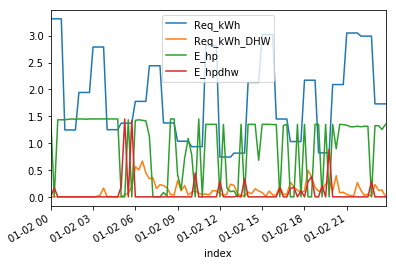

In [91]:
df[df.index.dayofyear==doy].Req_kWh.plot()
df[df.index.dayofyear==doy].Req_kWh_DHW.plot()

df[df.index.dayofyear==doy].E_hp.plot()
df[df.index.dayofyear==doy].E_hpdhw.plot()

plt.legend()


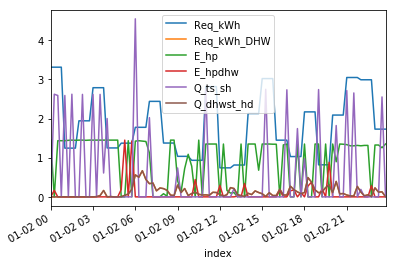

In [92]:
df[df.index.dayofyear==doy].Req_kWh.plot()
df[df.index.dayofyear==doy].Req_kWh_DHW.plot()

df[df.index.dayofyear==doy].E_hp.plot()
df[df.index.dayofyear==doy].E_hpdhw.plot()

df[df.index.dayofyear==doy].Q_ts_sh.plot()
df[df.index.dayofyear==doy].Q_dhwst_hd.plot()

plt.legend()


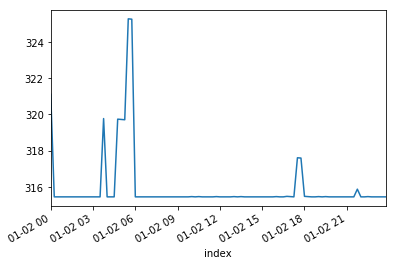

In [97]:
df[df.index.dayofyear==doy].T_ts.plot()


In [96]:
df.keys()

Index(['Bool_char', 'Bool_cons', 'Bool_dis', 'Bool_hp', 'Bool_hpdhw',
       'Bool_inj', 'E_PV_batt', 'E_PV_bu', 'E_PV_budhw', 'E_PV_curt',
       'E_PV_grid', 'E_PV_hp', 'E_PV_hpdhw', 'E_PV_load', 'E_batt_bu',
       'E_batt_budhw', 'E_batt_hp', 'E_batt_hpdhw', 'E_batt_load', 'E_bu',
       'E_budhw', 'E_char', 'E_cons', 'E_dis', 'E_grid_batt', 'E_grid_bu',
       'E_grid_budhw', 'E_grid_hp', 'E_grid_hpdhw', 'E_grid_load', 'E_hp',
       'E_hpdhw', 'E_loss_Batt', 'E_loss_conv', 'E_loss_inv', 'E_loss_inv_PV',
       'E_loss_inv_batt', 'E_loss_inv_grid', 'Q_dhwst_hd', 'Q_hp_sh',
       'Q_hp_ts', 'Q_loss_dhwst', 'Q_loss_ts', 'Q_ts', 'Q_ts_delta', 'Q_ts_sh',
       'SOC', 'T_dhwst', 'T_ts', 'E_demand', 'E_PV', 'Export_price', 'price',
       'Inv_P', 'Conv_P', 'Req_kWh', 'Req_kWh_DHW', 'Set_T', 'Temp',
       'Temp_supply', 'Temp_supply_tank', 'T_aux_supply', 'COP_tank', 'COP_SH',
       'COP_DHW', 'Cooling'],
      dtype='object')

In [103]:
(df[df.index.dayofyear==doy].Q_ts_sh+df[df.index.dayofyear==doy].Q_hp_sh-df[df.index.dayofyear==doy].Req_kWh).resample('2H').sum()

index
2017-01-02 00:00:00+01:00    4.884981e-15
2017-01-02 02:00:00+01:00    4.884981e-15
2017-01-02 04:00:00+01:00    1.332268e-15
2017-01-02 06:00:00+01:00    8.881784e-16
2017-01-02 08:00:00+01:00   -8.881784e-16
2017-01-02 10:00:00+01:00    9.992007e-16
2017-01-02 12:00:00+01:00    1.110223e-16
2017-01-02 14:00:00+01:00    4.884981e-15
2017-01-02 16:00:00+01:00   -1.776357e-15
2017-01-02 18:00:00+01:00   -7.549517e-15
2017-01-02 20:00:00+01:00    8.881784e-16
2017-01-02 22:00:00+01:00    1.110223e-15
Freq: 2H, dtype: float64

In [87]:
df.Q_ts_sh.sum()-df.Req_kWh.sum()

3.637978807091713e-12

In [41]:
df.E_cons.max()*4

6.375829766337875

In [16]:
df.keys()

Index(['Bool_char', 'Bool_cons', 'Bool_dis', 'Bool_hp', 'Bool_hpdhw',
       'Bool_inj', 'E_PV_batt', 'E_PV_bu', 'E_PV_budhw', 'E_PV_curt',
       'E_PV_grid', 'E_PV_hp', 'E_PV_hpdhw', 'E_PV_load', 'E_batt_bu',
       'E_batt_budhw', 'E_batt_hp', 'E_batt_hpdhw', 'E_batt_load', 'E_bu',
       'E_budhw', 'E_char', 'E_cons', 'E_dis', 'E_grid_batt', 'E_grid_bu',
       'E_grid_budhw', 'E_grid_hp', 'E_grid_hpdhw', 'E_grid_load', 'E_hp',
       'E_hpdhw', 'E_loss_Batt', 'E_loss_conv', 'E_loss_inv', 'E_loss_inv_PV',
       'E_loss_inv_batt', 'E_loss_inv_grid', 'Q_dhwst_hd', 'Q_hp_sh',
       'Q_hp_ts', 'Q_loss_dhwst', 'Q_loss_ts', 'Q_ts', 'Q_ts_delta', 'Q_ts_sh',
       'SOC', 'T_dhwst', 'T_ts', 'E_demand', 'E_PV', 'Export_price', 'price',
       'Inv_P', 'Conv_P', 'Req_kWh', 'Req_kWh_DHW', 'Set_T', 'Temp',
       'Temp_supply', 'Temp_supply_tank', 'T_aux_supply', 'COP_tank', 'COP_SH',
       'COP_DHW', 'Cooling'],
      dtype='object')

In [ ]:
df.

In [155]:
df.Req_kWh.sum()/140

146.8094326862613

In [108]:
print(df.E_hp.sum())
print(df.E_hpdhw.sum())

7247.288556758294
1413.4264894772966


In [109]:
df.loc[:,['E_cons','E_hp','E_hpdhw']].max()

E_cons     3.792154
E_hp       3.769543
E_hpdhw    1.450000
dtype: float64

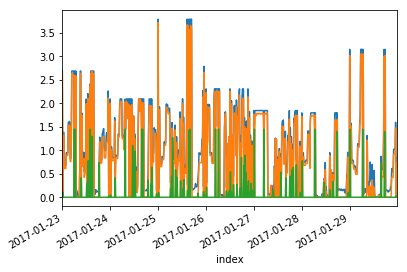

In [110]:
df[df.index.week==4].E_cons.plot()
df[df.index.week==4].E_grid_hp.plot()
df[df.index.week==4].E_grid_hpdhw.plot()

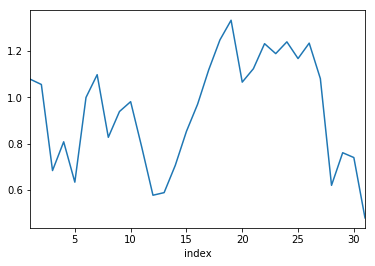

In [111]:
df[df.index.month==1].groupby([df[df.index.month==1].index.day]).mean().E_cons.plot()

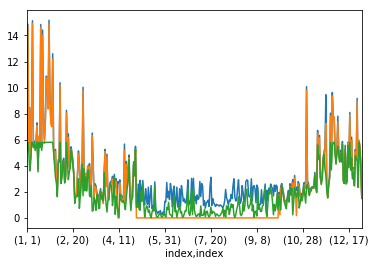

In [112]:
(df.groupby([df.index.month,df.index.day]).max().E_cons*4).plot()
(df.groupby([df.index.month,df.index.day]).max().E_grid_hp*4).plot()
(df.groupby([df.index.month,df.index.day]).max().E_grid_hpdhw*4).plot()


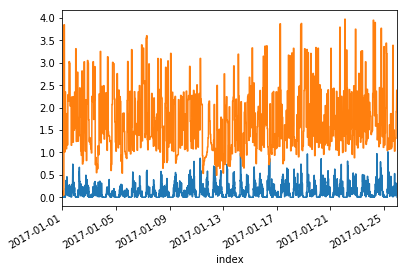

In [113]:

(df.loc[df.index.dayofyear<=25].Req_kWh_DHW).plot()
(df.loc[df.index.dayofyear<=25].Req_kWh).plot()

In [133]:
df.keys()

Index(['Bool_char', 'Bool_cons', 'Bool_dis', 'Bool_hp', 'Bool_hpdhw',
       'Bool_inj', 'E_PV_batt', 'E_PV_bu', 'E_PV_budhw', 'E_PV_curt',
       'E_PV_grid', 'E_PV_hp', 'E_PV_hpdhw', 'E_PV_load', 'E_batt_bu',
       'E_batt_budhw', 'E_batt_hp', 'E_batt_hpdhw', 'E_batt_load', 'E_bu',
       'E_budhw', 'E_char', 'E_cons', 'E_dis', 'E_grid_batt', 'E_grid_bu',
       'E_grid_budhw', 'E_grid_hp', 'E_grid_hpdhw', 'E_grid_load', 'E_hp',
       'E_hpdhw', 'E_loss_Batt', 'E_loss_conv', 'E_loss_inv', 'E_loss_inv_PV',
       'E_loss_inv_batt', 'E_loss_inv_grid', 'Q_dhwst_hd', 'Q_hp_sh',
       'Q_hp_ts', 'Q_loss_dhwst', 'Q_loss_ts', 'Q_ts', 'Q_ts_delta', 'Q_ts_sh',
       'SOC', 'T_dhwst', 'T_ts', 'E_demand', 'E_PV', 'Export_price', 'price',
       'Inv_P', 'Conv_P', 'Req_kWh', 'Req_kWh_DHW', 'Set_T', 'Temp',
       'Temp_supply', 'Temp_supply_tank', 'T_aux_supply', 'COP_tank', 'COP_SH',
       'COP_DHW', 'Cooling'],
      dtype='object')

In [150]:
(df[(df.index.dayofyear==25)].COP_tank).mean()

2.82

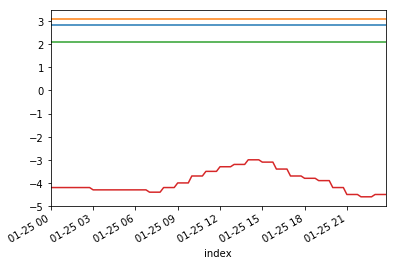

In [148]:
(df[(df.index.dayofyear==25)].COP_tank).plot()
(df[(df.index.dayofyear==25)].COP_SH).plot()

(df[(df.index.dayofyear==25)].COP_DHW).plot()
(df[(df.index.dayofyear==25)].Temp-273.15).plot()


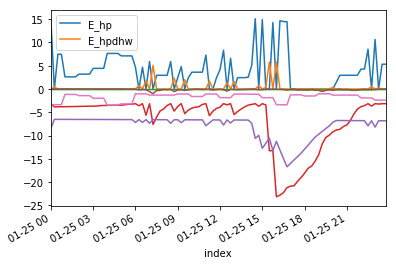

In [123]:
(df.loc[df.index.dayofyear==25,['E_hp','E_hpdhw']]*4).plot()
(-df.loc[df.index.dayofyear==25].price).plot()
(-df.loc[df.index.dayofyear==25].T_dhwst+310).plot()
(-df.loc[df.index.dayofyear==25].T_ts+310).plot()
(-df.loc[df.index.dayofyear==25].Req_kWh_DHW).plot()
(-df.loc[df.index.dayofyear==25].Req_kWh).plot()
#plt.legend()

In [163]:

df1=pd.read_csv('Output/df_110143956137_CH_PV50_NMC_0111_7_0111_SFH45.csv',engine='python',sep=',|;',index_col=[0],
                    parse_dates=[0],infer_datetime_format=True )
if np.issubdtype(df1.index.dtype, np.datetime64):
    df1.index=df.index.tz_localize('UTC').tz_convert('Europe/Brussels')
else:
    df1.index=pd.to_datetime(df1.index,utc=True)
    df1.index=df1.index.tz_convert('Europe/Brussels')

In [174]:
(df[df.index.dayofyear==25].E_cons*df[df.index.dayofyear==25].price).sum()

15.625720338286229

In [175]:
(df.groupby([df.index.month,df.index.day]).max().E_cons*4).reset_index(drop=True).iloc[24]*9.39*12/365

4.68273853423991

In [176]:
(df1[df1.index.dayofyear==25].E_cons*df1[df1.index.dayofyear==25].price).sum()

6.979414346118373

In [177]:
(df1.groupby([df1.index.month,df1.index.day]).max().E_cons*4).reset_index(drop=True).iloc[24]*9.39*12/365

0.91423645451426

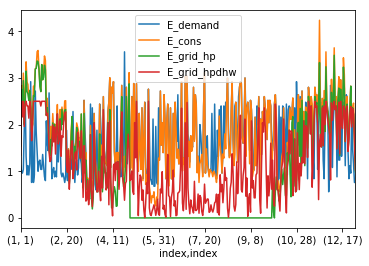

In [159]:
(df.groupby([df.index.month,df.index.day]).max().E_demand*4).plot()
(df.groupby([df.index.month,df.index.day]).max().E_cons*4).plot()
(df.groupby([df.index.month,df.index.day]).max().E_grid_hp*4).plot()
(df.groupby([df.index.month,df.index.day]).max().E_grid_hpdhw*4).plot()
plt.legend()

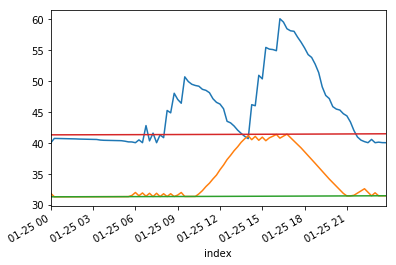

In [160]:
(df.loc[df.index.dayofyear==25].T_dhwst-273.15).plot()
(df.loc[df.index.dayofyear==25].T_ts-273.15).plot()
(df.loc[df.index.dayofyear==25].Temp_supply-273.15).plot()
(df.loc[df.index.dayofyear==25].Temp_supply-263.15).plot()

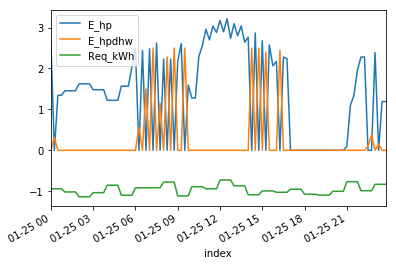

In [161]:
(df.loc[df.index.dayofyear==25,['E_hp','E_hpdhw']]*4).plot()

#(-df.loc[df.index.dayofyear==25].Req_kWh_DHW).plot()
(-df.loc[df.index.dayofyear==25].Req_kWh).plot()
plt.legend()

In [162]:
df.loc[df.index.dayofyear==25].Req_kWh.sum()

92.23302

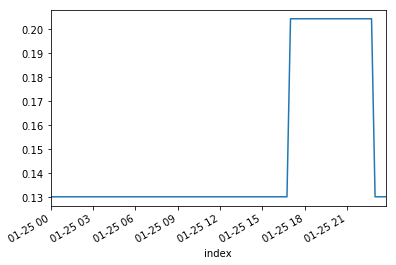

In [20]:
df[df.index.dayofyear==25].price.plot()

In [21]:

df1=pd.read_csv('Output/df_110143956137_CH_PV50_NMC_0111_7_1111_SFH100.csv',engine='python',sep=',|;',index_col=[0],
                    parse_dates=[0],infer_datetime_format=True )
if np.issubdtype(df1.index.dtype, np.datetime64):
    df1.index=df1.index.tz_localize('UTC').tz_convert('Europe/Brussels')
else:
    df1.index=pd.to_datetime(df.index,utc=True)
    df1.index=df1.index.tz_convert('Europe/Brussels')

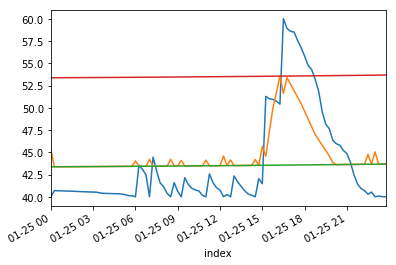

In [22]:
(df1.loc[df1.index.dayofyear==25].T_dhwst-273.15).plot()
(df1.loc[df1.index.dayofyear==25].T_ts-273.15).plot()
(df1.loc[df1.index.dayofyear==25].Temp_supply-273.15).plot()
(df1.loc[df1.index.dayofyear==25].Temp_supply-263.15).plot()

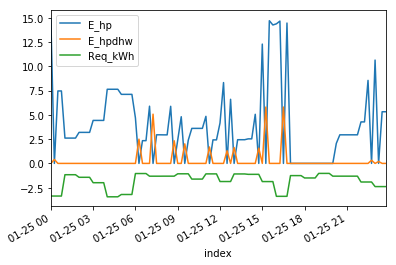

In [23]:
(df1.loc[df1.index.dayofyear==25,['E_hp','E_hpdhw']]*4).plot()

#(-df.loc[df.index.dayofyear==25].Req_kWh_DHW).plot()
(-df1.loc[df1.index.dayofyear==25].Req_kWh).plot()
plt.legend()

In [24]:
df1.E_grid_hp.max()

3.731638436424663

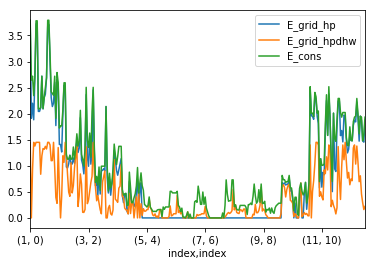

In [25]:
df1.groupby([df1.index.month,df1.index.hour]).max().E_grid_hp.plot()
df1.groupby([df1.index.month,df1.index.hour]).max().E_grid_hpdhw.plot()
df1.groupby([df1.index.month,df1.index.hour]).max().E_cons.plot()
plt.legend()

In [91]:

df=pd.read_csv('Output/df_110143956137_CH_PV50_NMC_0111_7_1111_SFH100.csv',engine='python',sep=',|;',index_col=[0],
                    parse_dates=[0],infer_datetime_format=True )
if np.issubdtype(df.index.dtype, np.datetime64):
    df.index=df.index.tz_localize('UTC').tz_convert('Europe/Brussels')
else:
    df.index=pd.to_datetime(df.index,utc=True)
    df.index=df.index.tz_convert('Europe/Brussels')

In [97]:
df.E_grid_hp.max()

3.731638436424663

In [98]:
df.E_dis.sum()

1668.2488396981307

In [101]:
df.E_batt_load.sum()

1127.1489911219894

In [99]:
df.E_batt_hpdhw.sum()

45.47180781036572

In [102]:
(df.E_batt_bu+df.E_batt_budhw+df.E_batt_hp+df.E_batt_hpdhw).sum()/df.E_dis.sum()

0.2743520005528989

In [29]:
df.E_batt_hp.sum()

348.83302887057107

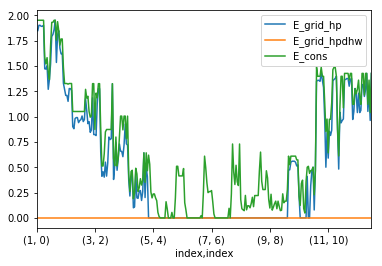

In [30]:
df.groupby([df.index.month,df.index.hour]).max().E_grid_hp.plot()
df.groupby([df.index.month,df.index.hour]).max().E_grid_hpdhw.plot()
df.groupby([df.index.month,df.index.hour]).max().E_cons.plot()
plt.legend()

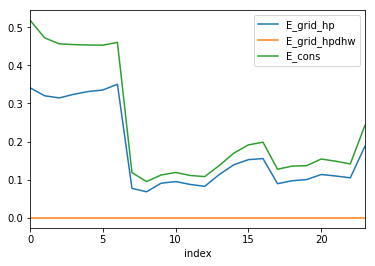

In [31]:
df.groupby([df.index.hour]).mean().E_grid_hp.plot()
df.groupby([df.index.hour]).mean().E_grid_hpdhw.plot()
df.groupby([df.index.hour]).mean().E_cons.plot()
plt.legend()

In [32]:

df=pd.read_csv('Output/df_110143956137_CH_PV50_NMC_0111_7_0111_SFH100.csv',engine='python',sep=',|;',index_col=[0],
                    parse_dates=[0],infer_datetime_format=True )
if np.issubdtype(df.index.dtype, np.datetime64):
    df.index=df.index.tz_localize('UTC').tz_convert('Europe/Brussels')
else:
    df.index=pd.to_datetime(df.index,utc=True)
    df.index=df.index.tz_convert('Europe/Brussels')

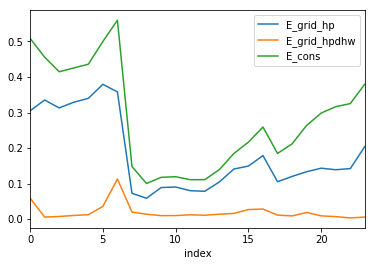

In [33]:
df.groupby([df.index.hour]).mean().E_grid_hp.plot()
df.groupby([df.index.hour]).mean().E_grid_hpdhw.plot()
df.groupby([df.index.hour]).mean().E_cons.plot()
plt.legend()

In [34]:
df.E_cons.sum()

9909.963247149859

In [35]:
(df.E_grid_hp*df.price).sum()

982.1647533128487

In [36]:
(df.E_grid_hp*.170811).sum()

1094.4951838405723

In [37]:
df.E_demand.sum()

4224.080000000001

In [38]:
df.loc[(df.E_dis>0)&(df.E_PV>0),['E_dis','E_PV_grid','E_PV_load','E_demand','E_cons']].sum()

E_dis        0.0
E_PV_grid    0.0
E_PV_load    0.0
E_demand     0.0
E_cons       0.0
dtype: float64

In [39]:
print(df.E_grid_hp.sum())
print(df[df.price>df.price.mean()].E_grid_hp.sum())
print(df[df.price<df.price.mean()].E_grid_hp.sum())
print(df[df.price>df.price.mean()].E_grid_hpdhw.sum())
print(df[df.price<df.price.mean()].E_grid_hpdhw.sum())


6407.638757694599
2001.5836907037174
4406.055066990883
179.51082390020963
502.4894730568518


In [40]:
df.keys()

Index(['Bool_char', 'Bool_cons', 'Bool_dis', 'Bool_hp', 'Bool_hpdhw',
       'Bool_inj', 'E_PV_batt', 'E_PV_bu', 'E_PV_budhw', 'E_PV_curt',
       'E_PV_grid', 'E_PV_hp', 'E_PV_hpdhw', 'E_PV_load', 'E_batt_bu',
       'E_batt_budhw', 'E_batt_hp', 'E_batt_hpdhw', 'E_batt_load', 'E_bu',
       'E_budhw', 'E_char', 'E_cons', 'E_dis', 'E_grid_batt', 'E_grid_bu',
       'E_grid_budhw', 'E_grid_hp', 'E_grid_hpdhw', 'E_grid_load', 'E_hp',
       'E_hpdhw', 'E_loss_Batt', 'E_loss_conv', 'E_loss_inv', 'E_loss_inv_PV',
       'E_loss_inv_batt', 'E_loss_inv_grid', 'Q_dhwst_hd', 'Q_hp_sh',
       'Q_hp_ts', 'Q_loss_dhwst', 'Q_loss_ts', 'Q_ts', 'Q_ts_delta', 'Q_ts_sh',
       'SOC', 'T_dhwst', 'T_ts', 'E_demand', 'E_PV', 'Export_price', 'price',
       'Inv_P', 'Conv_P', 'Req_kWh', 'Req_kWh_DHW', 'Set_T', 'Temp',
       'Temp_supply', 'Temp_supply_tank', 'T_aux_supply', 'COP_tank', 'COP_SH',
       'COP_DHW', 'Cooling'],
      dtype='object')

In [41]:
df.price.sum()

5985.216960000002

In [42]:
os.getcwd()

'/data/home/alejandropena/Project2/Paper1_last'

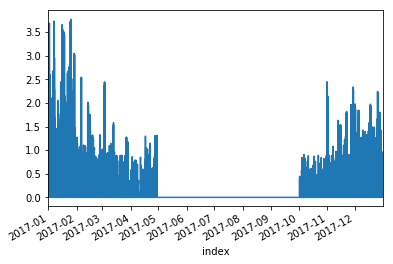

In [43]:
df.E_hp.plot()

In [44]:

df1=pd.read_csv('Output/df_110143956137_CH_PV50_NMC_0110_7_1110_SFH15.csv',engine='python',sep=',|;',index_col=[0],
                    parse_dates=[0],infer_datetime_format=True )
if np.issubdtype(df1.index.dtype, np.datetime64):
    df1.index=df1.index.tz_localize('UTC').tz_convert('Europe/Brussels')
else:
    df1.index=pd.to_datetime(df1.index,utc=True)
    df1.index=df1.index.tz_convert('Europe/Brussels')

In [45]:

df=pd.read_csv('Output/df_110143956137_CH_PV50_NMC_0111_7_1110_SFH15.csv',engine='python',sep=',|;',index_col=[0],
                    parse_dates=[0],infer_datetime_format=True )
if np.issubdtype(df.index.dtype, np.datetime64):
    df.index=df.index.tz_localize('UTC').tz_convert('Europe/Brussels')
else:
    df.index=pd.to_datetime(df.index,utc=True)
    df.index=df.index.tz_convert('Europe/Brussels')

In [46]:
df1[df.E_cons==df.E_cons.max()].E_cons

index
2017-08-28 00:00:00+02:00    0.73
Name: E_cons, dtype: float64

In [47]:
df[df.E_cons==df.E_cons.max()].E_cons

index
2017-08-28 00:00:00+02:00    0.73
Name: E_cons, dtype: float64

In [48]:
df1.E_cons.max()*4

10.02000000053784

In [49]:
df.E_cons.max()*4

2.92

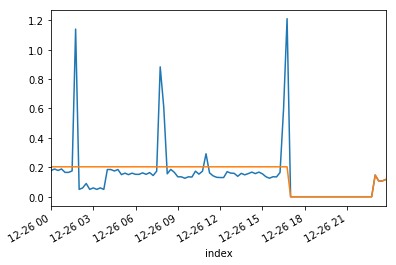

In [50]:
doy=360
df1.loc[df1.index.dayofyear==doy,'E_cons'].plot()
df.loc[df.index.dayofyear==doy,'E_cons'].plot()


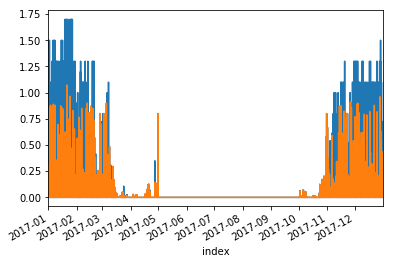

In [51]:
df1.E_hp.plot()
df.E_hp.plot()


In [52]:
(df1.E_hp-df.E_hp).sum()

1.0845250895434488

In [53]:
df.keys()

Index(['Bool_char', 'Bool_cons', 'Bool_dis', 'Bool_hp', 'Bool_hpdhw',
       'Bool_inj', 'E_PV_batt', 'E_PV_bu', 'E_PV_budhw', 'E_PV_curt',
       'E_PV_grid', 'E_PV_hp', 'E_PV_hpdhw', 'E_PV_load', 'E_batt_bu',
       'E_batt_budhw', 'E_batt_hp', 'E_batt_hpdhw', 'E_batt_load', 'E_bu',
       'E_budhw', 'E_char', 'E_cons', 'E_dis', 'E_grid_batt', 'E_grid_bu',
       'E_grid_budhw', 'E_grid_hp', 'E_grid_hpdhw', 'E_grid_load', 'E_hp',
       'E_hpdhw', 'E_loss_Batt', 'E_loss_conv', 'E_loss_inv', 'E_loss_inv_PV',
       'E_loss_inv_batt', 'E_loss_inv_grid', 'Q_dhwst_hd', 'Q_hp_sh',
       'Q_hp_ts', 'Q_loss_dhwst', 'Q_loss_ts', 'Q_ts', 'Q_ts_delta', 'Q_ts_sh',
       'SOC', 'T_dhwst', 'T_ts', 'E_demand', 'E_PV', 'Export_price', 'price',
       'Inv_P', 'Conv_P', 'Req_kWh', 'Req_kWh_DHW', 'Set_T', 'Temp',
       'Temp_supply', 'Temp_supply_tank', 'T_aux_supply', 'COP_tank', 'COP_SH',
       'COP_DHW', 'Cooling'],
      dtype='object')

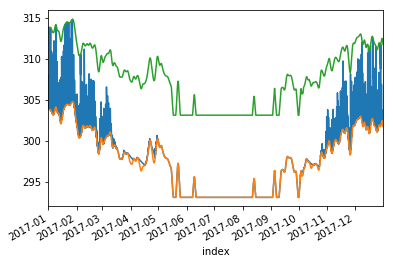

In [54]:
df.T_ts.plot()
df.Temp_supply.plot()
(df.Temp_supply+10).plot()

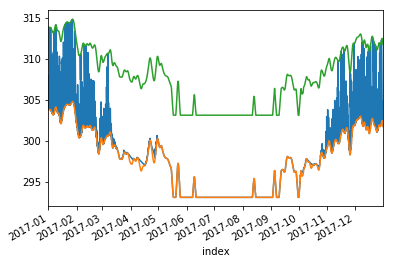

In [55]:
df1.T_ts.plot()
df1.Temp_supply.plot()
(df1.Temp_supply+10).plot()

In [56]:
df.loc[(df.E_hp>0.01)&(df.E_hpdhw>0.01),['E_hp','E_hpdhw']].round(1)

,E_hp,E_hpdhw
index,,


In [57]:
df.loc[(df.E_dis>.01)&(df.E_char>.01),['E_dis','E_char']].round(2).sum()

E_dis     0.0
E_char    0.0
dtype: float64

In [58]:
df.loc[(df.E_cons>.01)&(df.E_PV_grid>.01),['E_cons','E_PV_grid']].sum()

E_cons       0.0
E_PV_grid    0.0
dtype: float64

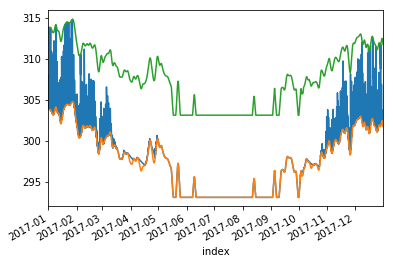

In [59]:
df.T_ts.plot()
df.Temp_supply.plot()
(df.Temp_supply+10).plot()
plt.show()


In [60]:
df.E_dis.sum()

1487.3314314991953

In [61]:

df.sum().round(1)

Bool_char              15554.0
Bool_cons              27072.0
Bool_dis               19486.0
Bool_hp                35040.0
Bool_hpdhw                 0.0
Bool_inj                7968.0
E_PV_batt               1460.4
E_PV_bu                    3.0
E_PV_budhw                 0.0
E_PV_curt                328.7
E_PV_grid               3012.6
E_PV_hp                  226.8
E_PV_hpdhw                 0.0
E_PV_load               1324.7
E_batt_bu                  0.2
E_batt_budhw               0.0
E_batt_hp                 24.1
E_batt_hpdhw               0.0
E_batt_load             1388.6
E_bu                       3.2
E_budhw                    0.0
E_char                  1671.2
E_cons                  2441.7
E_dis                   1487.3
E_grid_batt              210.7
E_grid_bu                  0.0
E_grid_budhw               0.0
E_grid_hp                709.6
E_grid_hpdhw               0.0
E_grid_load             1510.8
                       ...    
E_loss_inv_batt           74.4
E_loss_i

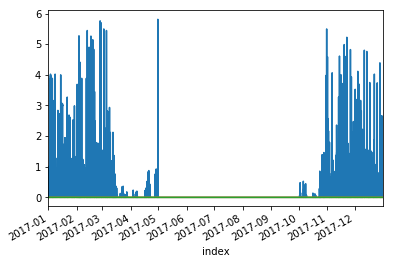

In [62]:
df.Q_hp_ts.plot()
df.Q_dhwst_hd.plot()
df.Q_hp_sh.plot()

plt.show()

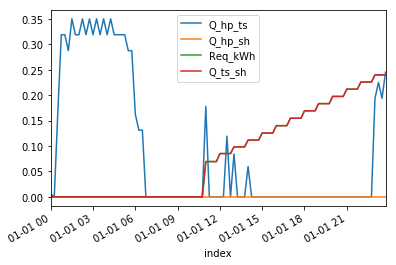

In [63]:
df.loc[df.index.dayofyear==1,['Q_hp_ts','Q_hp_sh','Req_kWh','Q_ts_sh']].plot()

In [64]:
df[df.E_hp==df.E_hp.max()].E_hp

index
2017-01-21 16:45:00+01:00    1.072652
Name: E_hp, dtype: float64

In [65]:
8*.66

5.28

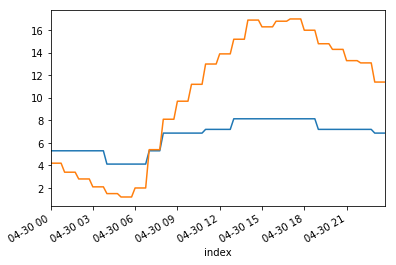

In [66]:
df[df.index.dayofyear==120].COP_tank.plot()
(df[df.index.dayofyear==120].Temp-273.15).plot()

In [67]:
df.SOC.max()

6.743064990780157

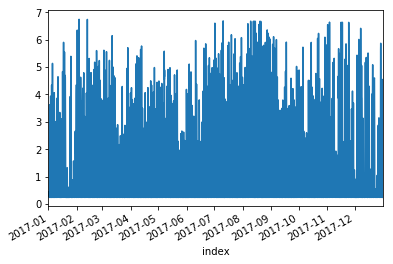

In [68]:
df.SOC.plot()

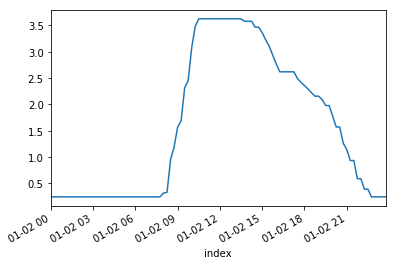

In [69]:
df[df.index.dayofyear==2].SOC.plot()

In [70]:
import pickle
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

aux_dict=load_obj('Output/aux_dict')
param=load_obj('Output/param')

In [71]:
design_param=load_obj('Input/dict_design')

In [72]:
design_param

{'hl_dt15': 2.098,
 'hl_dt45': 6.293,
 'hl_dt100': 13.984,
 'design_temp': -10.186270292253306,
 'T_din_15_45': 35,
 'T_dout_15_45': 30,
 'T_din_100': 55,
 'T_dout_100': 45,
 'rad_exp_15_45': 1.1,
 'rad_exp_100': 1.3,
 'hp_15': 4,
 'hp_45': 8,
 'hp_100': 16,
 'bu_15': 0.0,
 'bu_45': 1.0,
 'bu_100': 6.0}

In [73]:
df1=pd.read_csv('Output/aggregated_results.csv',sep=';').drop_duplicates()
print(df1.shape)
print(df1.keys())
print(26928-df1.shape[0])

(26916, 93)
Index(['E_PV_batt', 'E_PV_bu', 'E_PV_budhw', 'E_PV_curt', 'E_PV_grid',
       'E_PV_hp', 'E_PV_hpdhw', 'E_PV_load', 'E_batt_bu', 'E_batt_budhw',
       'E_batt_hp', 'E_batt_hpdhw', 'E_batt_load', 'E_bu', 'E_budhw', 'E_char',
       'E_cons', 'E_dis', 'E_grid_batt', 'E_grid_bu', 'E_grid_budhw',
       'E_grid_hp', 'E_grid_hpdhw', 'E_grid_load', 'E_hp', 'E_hpdhw',
       'E_loss_Batt', 'E_loss_conv', 'E_loss_inv', 'E_loss_inv_PV',
       'E_loss_inv_batt', 'E_loss_inv_grid', 'Q_dhwst_hd', 'Q_hp_sh',
       'Q_hp_ts', 'Q_loss_dhwst', 'Q_loss_ts', 'Q_ts', 'Q_ts_delta', 'Q_ts_sh',
       'T_dhwst', 'T_ts', 'E_demand', 'E_PV', 'Req_kWh', 'Req_kWh_DHW',
       'Set_T', 'Temp', 'Temp_supply', 'Temp_supply_tank', 'T_aux_supply',
       'COP_tank', 'COP_SH', 'COP_DHW', 'E_demand_hp_pv_dhw', 'E_demand_hp_pv',
       'E_demand_pv', 'TSC', 'DSC', 'ISC', 'CU', 'EFC_nolifetime', 'BS', 'LS1',
       'LS2', 'LS3', 'LS4', 'LS5', 'PS1', 'PS2', 'PS3', 'PS4', 'PS5',
       'App_comb', 'conf', '

In [74]:
param['hp'].power

8

In [75]:
aux_dict.keys()

dict_keys(['aux_Cap_arr', 'SOH_arr', 'Cycle_aging_factor', 'P_max_arr', 'results_arr', 'cycle_cal_arr', 'DoD_arr', 'results'])

In [76]:
df=pd.read_csv('Output/aggregated_results.csv',sep=';')

In [77]:
df[(df.hh==110143956137)&(df.conf==6)&(df.house_type=='SFH100')]

,E_PV_batt,E_PV_bu,E_PV_budhw,E_PV_curt,E_PV_grid,E_PV_hp,E_PV_hpdhw,E_PV_load,E_batt_bu,E_batt_budhw,...,house_type,HP,SOC_mean,P_drained_max,P_injected_max,last_cap,cap_fading,last_SOH,cycle_to_total,Bill
12363,1373.266887,2.497732,0.0,328.180195,2622.858845,759.143634,0.0,1265.811771,-6.962868e-14,0.0,...,SFH100,AS,31.658935,26.820000,3.64,6.835492,2.350119,0.921918,0.597260,1464.011371
16193,1365.433840,2.910219,0.0,328.007178,2622.819403,771.083771,0.0,1261.101128,2.313283e-01,0.0,...,SFH100,AS,25.068873,7.807963,3.64,6.845910,2.201286,0.926806,0.410959,1620.224521


In [78]:
df.keys()

Index(['E_PV_batt', 'E_PV_bu', 'E_PV_budhw', 'E_PV_curt', 'E_PV_grid',
       'E_PV_hp', 'E_PV_hpdhw', 'E_PV_load', 'E_batt_bu', 'E_batt_budhw',
       'E_batt_hp', 'E_batt_hpdhw', 'E_batt_load', 'E_bu', 'E_budhw', 'E_char',
       'E_cons', 'E_dis', 'E_grid_batt', 'E_grid_bu', 'E_grid_budhw',
       'E_grid_hp', 'E_grid_hpdhw', 'E_grid_load', 'E_hp', 'E_hpdhw',
       'E_loss_Batt', 'E_loss_conv', 'E_loss_inv', 'E_loss_inv_PV',
       'E_loss_inv_batt', 'E_loss_inv_grid', 'Q_dhwst_hd', 'Q_hp_sh',
       'Q_hp_ts', 'Q_loss_dhwst', 'Q_loss_ts', 'Q_ts', 'Q_ts_delta', 'Q_ts_sh',
       'T_dhwst', 'T_ts', 'E_demand', 'E_PV', 'Req_kWh', 'Req_kWh_DHW',
       'Set_T', 'Temp', 'Temp_supply', 'Temp_supply_tank', 'T_aux_supply',
       'COP_tank', 'COP_SH', 'COP_DHW', 'E_demand_hp_pv_dhw', 'E_demand_hp_pv',
       'E_demand_pv', 'TSC', 'DSC', 'ISC', 'CU', 'EFC_nolifetime', 'BS', 'LS1',
       'LS2', 'LS3', 'LS4', 'LS5', 'PS1', 'PS2', 'PS3', 'PS4', 'PS5',
       'App_comb', 'conf', 'Capacity', '

In [79]:
df.groupby([df.App_comb,df.conf,df.house_type]).E_PV_grid.mean()*0.04

App_comb  conf  house_type
2.0       0.0   SFH100        178.328643
                SFH15         193.480794
                SFH45         185.828207
          1.0   SFH100        142.837259
                SFH15         158.911711
                SFH45         153.807245
          2.0   SFH100        162.175228
                SFH15         186.089776
                SFH45         173.809425
          3.0   SFH100        135.923694
                SFH15         155.605605
                SFH45         148.217312
          4.0   SFH100        136.113677
                SFH15         153.194182
                SFH45         143.875381
          5.0   SFH100        110.366752
                SFH15         125.654841
                SFH45         120.154287
          6.0   SFH100        132.664887
                SFH15         152.768111
                SFH45         143.197891
          7.0   SFH100        109.972513
                SFH15         125.789182
                SFH45         

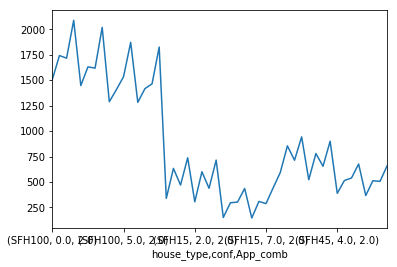

In [80]:
df.groupby([df.house_type,df.conf,df.App_comb]).mean().Bill.plot()

In [81]:
df[(df.hh==110143956137)&(df.conf==2)&(df.App_comb==2)&(df.house_type=='SFH15')]

,E_PV_batt,E_PV_bu,E_PV_budhw,E_PV_curt,E_PV_grid,E_PV_hp,E_PV_hpdhw,E_PV_load,E_batt_bu,E_batt_budhw,...,house_type,HP,SOC_mean,P_drained_max,P_injected_max,last_cap,cap_fading,last_SOH,cycle_to_total,Bill
0,0.0,1.34713,0.0,407.201892,4191.589898,318.392014,0.0,1487.614181,0.0,0.0,...,SFH15,AS,3.5,7.52,3.64,6.86,2.0,0.933516,0.0,530.517468


In [82]:

df=pd.read_csv('Output/df_110144756389_CH_PV50_NMC_1111_7.0_1111_mean.csv',engine='python',sep=',|;',index_col=[0],
                    parse_dates=[0],infer_datetime_format=True )
df.index=df.index.tz_localize('UTC').tz_convert('Europe/Brussels')

FileNotFoundError: [Errno 2] No such file or directory: 'Output/df_110144756389_CH_PV50_NMC_1111_7.0_1111_mean.csv'

In [ ]:
df.E_demand.groupby([df.index.hour,df.index.minute]).mean().plot()
df.E_cons.groupby([df.index.hour,df.index.minute]).mean().plot()
plt.show()

In [ ]:
df.E_PV_curt.sum()/df.E_PV.sum()*100

In [ ]:
df.keys()[:50]

In [ ]:
df.E_hp.max()

In [ ]:
df.loc[df.E_hp==df.E_hp.max(),['E_bu','E_hp','Req_kWh','COP_SH','Q_ts_sh','Temp']]

In [ ]:
df.loc[df.E_bu>0.001,['E_bu','E_hp','Req_kWh','COP_SH','Q_ts_sh']]

In [ ]:
df.head()

In [ ]:
df.COP_SH.plot()
df.COP_DHW.plot()

plt.show()


In [ ]:
doy=124
df[(df.index.dayofyear>=doy)].E_hp_cooling.plot()

df[(df.index.dayofyear>=doy)].Q_ts_sh.plot()
((df[(df.index.dayofyear>=doy)].T_ts-273.15)/10).plot()
df[(df.index.dayofyear>=doy)].Req_kWh.plot()
df[(df.index.dayofyear>=doy)].E_PV_hp.plot()
plt.legend()
plt.show()

In [ ]:
doy=164

#df[(df.index.dayofyear==doy)].E_PV.plot()
df[(df.index.dayofyear==doy)].E_PV_hpdhw.plot()
df[(df.index.dayofyear==doy)].E_PV_hp.plot()
(-df[(df.index.dayofyear==doy)].E_cons).plot()
#df[(df.index.dayofyear==doy)].E_PV_curt.plot()
df[(df.index.dayofyear==doy)].E_demand.plot()
df[(df.index.dayofyear==doy)].E_hp.plot()
df[(df.index.dayofyear==doy)].E_hp_cooling.plot()
#df[(df.index.dayofyear==doy)].COP_SH.plot()
(df[(df.index.dayofyear==doy)].E_hpdhw*10).plot()
(df[(df.index.dayofyear==doy)].Q_dhwst_hd*10).plot()
#((df[(df.index.dayofyear==doy)].T_dhwst-273.15)/10).plot()
df[(df.index.dayofyear==doy)].Req_kWh.plot()
#df[(df.index.dayofyear==doy)].Req_kWh_DHW.plot()
plt.legend()
plt.show()

In [ ]:
l=[name for name in os.listdir('Output/') if 'df' in name]
    

In [ ]:
app=[]
conf=[]
for i in l:
    app.append(i.split('_')[5])
    conf.append(i.split('_')[7])


In [ ]:
len(l)

In [ ]:
aux=pd.DataFrame(np.array([app,conf]).T,columns=['app','conf'])

In [ ]:
aux.loc[:,'app']=aux.loc[:,'app'].replace('0100',0)
aux.loc[:,'app']=aux.loc[:,'app'].replace('0101',1)
aux.loc[:,'app']=aux.loc[:,'app'].replace('0110',2)
aux.loc[:,'app']=aux.loc[:,'app'].replace('0111',3)
aux.loc[:,'app']=aux.loc[:,'app'].replace('1100',4)
aux.loc[:,'app']=aux.loc[:,'app'].replace('1101',5)
aux.loc[:,'app']=aux.loc[:,'app'].replace('1110',6)
aux.loc[:,'app']=aux.loc[:,'app'].replace('1111',7)

aux.loc[:,'conf']=aux.loc[:,'conf'].replace('0100',0)
aux.loc[:,'conf']=aux.loc[:,'conf'].replace('0110',1)
aux.loc[:,'conf']=aux.loc[:,'conf'].replace('0111',2)
aux.loc[:,'conf']=aux.loc[:,'conf'].replace('1100',3)
aux.loc[:,'conf']=aux.loc[:,'conf'].replace('1110',4)
aux.loc[:,'conf']=aux.loc[:,'conf'].replace('1111',5)


In [ ]:
aux

In [ ]:
os.listdir('Output/')

In [ ]:
df.E_hpdhw.sum().round(1)

In [ ]:
df[df.Q_ts_sh>0].Q_ts_sh.sum().round(1)

In [ ]:
df[df.Q_ts_sh<0].Q_ts_sh.sum().round(1)

In [ ]:
26102.0+5728.3

In [ ]:
df.E_hpdhw.sum().round(1)

In [ ]:
df.sum().round(1)

In [ ]:
df.sum().round(1)